In [1]:
import os
import pandas as pd
import PIL

import torch
from torch.utils.data import Dataset, DataLoader

from torchvision.io import read_image

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        self.imgs = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if isinstance(img, str):
          img = read_image(img)
        #else:
        #  image = Image.fromarray(img.astype('unint8'), 'RGB') risolto mettendo prima ToTensor() nel transform
        label = self.targets[idx]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

In [3]:
data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
size = 32

# simclr DA pipeline
s=1
color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.RandomResizedCrop(size=size),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomApply([color_jitter], p=0.8),
                                  transforms.RandomGrayscale(p=0.2),
                                  transforms.GaussianBlur(kernel_size=int(0.1 * size))])

# create training set from CustomDataset
trainset = CustomImageDataset(data.data, data.targets, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 45.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


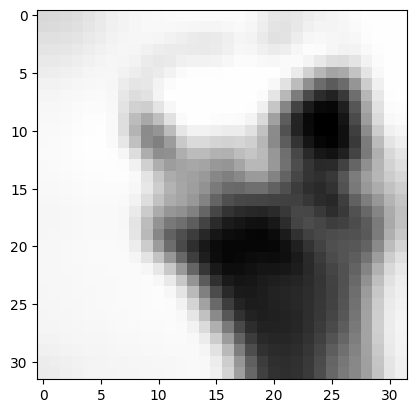

Label: 2


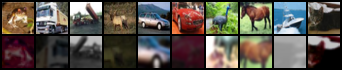

In [5]:
import matplotlib.pyplot as plt

# Display image and label.
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")


# use this
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)


from torchvision.utils import make_grid
imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))#,
                    #*[trainset[i][1] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

## Exercise 1
Create the custom training set using the cifar10 images and targets

## Exercise 2
Modify the custom dataset to return two different views of an input image and create a train loop as the following example

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        self.imgs = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_base = self.imgs[idx]
        if isinstance(img_base, str):
          img_base = read_image(img_base)
        label = self.targets[idx]
        if self.transform:
            img1 = self.transform(img_base)
            img2 = self.transform(img_base)
        else:
            img1 = img_base
            img2 = img_base
        if self.target_transform:
            label = self.target_transform(label)
        return img1, img2, label

In [7]:
data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
size = 32

# simclr DA pipeline
s=1
color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.RandomResizedCrop(size=size),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomApply([color_jitter], p=0.8),
                                  transforms.RandomGrayscale(p=0.2),
                                  transforms.GaussianBlur(kernel_size=int(0.1 * size))])

# create training set from CustomDataset
trainset = CustomImageDataset(data.data, data.targets, transform=transform)

Files already downloaded and verified


In [8]:
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


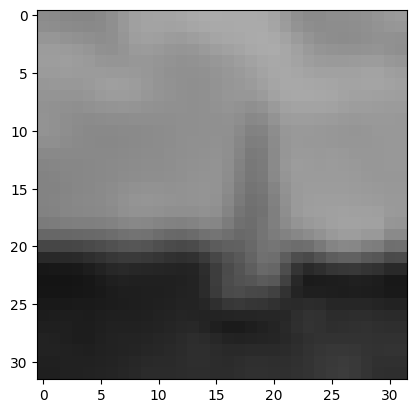

Label: 8


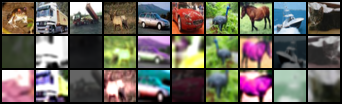

In [29]:
# Display image and label.
train_features, train_features2, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")


from torchvision.utils import make_grid
imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)],
                    *[trainset[i][1] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

In [10]:
# training loop
for idx, data in enumerate(dataloader):
    views1, views2, targets = data
    print(views1.shape)
    print(views2.shape)
    if idx == 3:
        break

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])


## Exercise 3

Plot a positive pair and a negative pair of a mini-batch of sample

In [40]:
#TODO fare una positive e negative pair basata su etichetta, e una senza (unsupervised)
# Unsupervised
found = False
positive_pair = []
positive_label = None
negative_pair = []
for idx, data in enumerate(dataloader):
    views1, views2, targets = data
    positive_pair.append(views1[0])
    positive_label = targets[0]

    for i in range(len(views1)):
        if i == 0:
            positive_pair.append(views1[i])
            positive_pair.append(views2[i])
        else:
            negative_pair.append(views1[i])
            negative_pair.append(views2[i])
            found = True
        if found:
            break
    if found:
        break

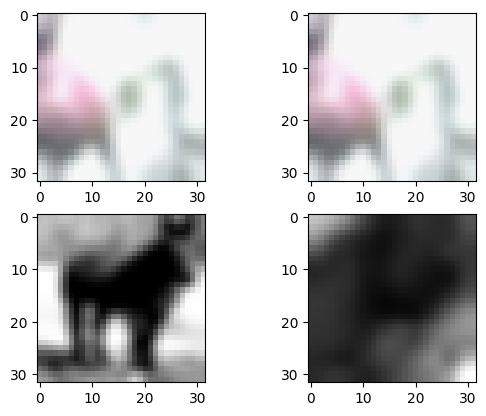

In [41]:
# Plot pairs
fig,axis = plt.subplots(2,2)
axis[0, 0].imshow(positive_pair[0].permute(1, 2, 0))
axis[0, 1].imshow(positive_pair[1].permute(1, 2, 0))
axis[1, 0].imshow(negative_pair[0].permute(1, 2, 0))
axis[1, 1].imshow(negative_pair[1].permute(1, 2, 0))
plt.show()

In [45]:
# Label based
found = False
positive_pair = []
negative_pair = []
for idx, data in enumerate(dataloader):
    views1, views2, targets = data
    for i in range(len(views1)):
        if i == 0:
            positive_pair.append(views1[i])
            positive_pair.append(views2[i])
            positive_label = targets[i]
        else:
            if targets[i] != positive_label:
                negative_pair.append(views1[i])
                negative_pair.append(views2[i])
                found = True
        if found:
            break
    if found:
        break

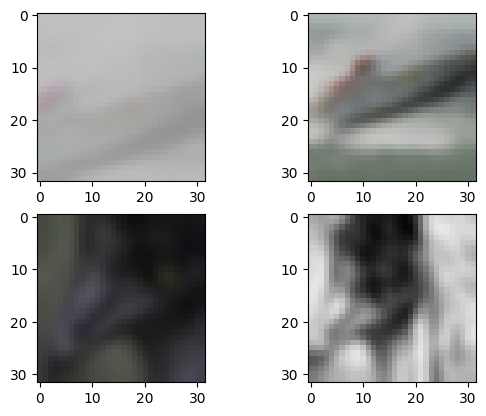

In [46]:
fig,axis = plt.subplots(2,2)
axis[0, 0].imshow(positive_pair[0].permute(1, 2, 0))
axis[0, 1].imshow(positive_pair[1].permute(1, 2, 0))
axis[1, 0].imshow(negative_pair[0].permute(1, 2, 0))
axis[1, 1].imshow(negative_pair[1].permute(1, 2, 0))
plt.show()